In [51]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [54]:
num_records = 500

# Generating the first batch (clean sales data)
data_batch1 = {
    'order_id': [f'ORD{1000 + i}' for i in range(num_records)],
    'customer_id': [f'CUST{random.randint(100, 199)}' for _ in range(num_records)],
    'date': [datetime(2023, 1, 1) + timedelta(days=random.randint(0, 60)) for _ in range(num_records)],
    'revenue': np.round(np.random.uniform(100.0, 1000.0, num_records), 2),
    'product_category': [random.choice(['Electronics', 'Clothing', 'Books', 'Home']) for _ in range(num_records)]
}

df_batch1 = pd.DataFrame(data_batch1)
df_batch1.to_csv('sales_data_batch1.csv', index=False)

df_batch1.head()

,order_id,customer_id,date,revenue,product_category
0,ORD1000,CUST154,2023-02-03,236.96,Clothing
1,ORD1001,CUST131,2023-01-28,811.33,Clothing
2,ORD1002,CUST193,2023-02-15,771.13,Clothing
3,ORD1003,CUST112,2023-02-12,821.46,Clothing
4,ORD1004,CUST113,2023-02-21,724.39,Home


In [55]:
df_batch2 = df_batch1.copy()

df_batch2['date'] = df_batch2['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
df_batch2['discount'] = np.round(np.random.uniform(5.0, 50.0, num_records), 2)
df_batch2['revenue'] = np.round(np.random.uniform(1500.0, 1500.0, num_records), 2)
df_batch2.loc[df_batch2.sample(frac=0.1).index, 'product_category'] = None

df_batch2.to_csv('sales_data_batch2.csv', index=False)

df_batch2.head()

,order_id,customer_id,date,revenue,product_category,discount
0,ORD1000,CUST154,2023-02-03 00:00:00,1500.0,Clothing,31.23
1,ORD1001,CUST131,2023-01-28 00:00:00,1500.0,Clothing,7.19
2,ORD1002,CUST193,2023-02-15 00:00:00,1500.0,Clothing,12.06
3,ORD1003,CUST112,2023-02-12 00:00:00,1500.0,Clothing,49.06
4,ORD1004,CUST113,2023-02-21 00:00:00,1500.0,Home,14.51


In [13]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [56]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DataQualityAndDriftDetection") \
    .getOrCreate()

In [57]:
df_batch1 = spark.read.csv('sales_data_batch1.csv', header=True, inferSchema=True)

df_batch2 = spark.read.csv('sales_data_batch2.csv', header=True, inferSchema=True)

In [58]:
print("Sample from Batch 1:")
df_batch1.show(5)

print("Sample from Batch 2:")
df_batch2.show(5)

Sample from Batch 1:
+--------+-----------+----------+-------+----------------+
|order_id|customer_id|      date|revenue|product_category|
+--------+-----------+----------+-------+----------------+
| ORD1000|    CUST154|2023-02-03| 236.96|        Clothing|
| ORD1001|    CUST131|2023-01-28| 811.33|        Clothing|
| ORD1002|    CUST193|2023-02-15| 771.13|        Clothing|
| ORD1003|    CUST112|2023-02-12| 821.46|        Clothing|
| ORD1004|    CUST113|2023-02-21| 724.39|            Home|
+--------+-----------+----------+-------+----------------+
only showing top 5 rows

Sample from Batch 2:
+--------+-----------+-------------------+-------+----------------+--------+
|order_id|customer_id|               date|revenue|product_category|discount|
+--------+-----------+-------------------+-------+----------------+--------+
| ORD1000|    CUST154|2023-02-03 00:00:00| 1500.0|        Clothing|   31.23|
| ORD1001|    CUST131|2023-01-28 00:00:00| 1500.0|        Clothing|    7.19|
| ORD1002|    CUS

In [59]:
print("Schema of Batch 1:")
df_batch1.printSchema()

print("\nSchema of Batch 2:")
df_batch2.printSchema()

Schema of Batch 1:
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- revenue: double (nullable = true)
 |-- product_category: string (nullable = true)


Schema of Batch 2:
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- revenue: double (nullable = true)
 |-- product_category: string (nullable = true)
 |-- discount: double (nullable = true)



In [60]:
# Extract (column_name, data_type) for each batch
schema_batch1 = set((field.name, str(field.dataType)) for field in df_batch1.schema.fields)
schema_batch2 = set((field.name, str(field.dataType)) for field in df_batch2.schema.fields)

# Find columns that are different
new_columns = schema_batch2 - schema_batch1

missing_columns = schema_batch1 - schema_batch2

# Find columns with same name but different types
common_columns = set(field.name for field in df_batch1.schema.fields).intersection(
    set(field.name for field in df_batch2.schema.fields)
)

type_mismatches = []
for col in common_columns:
    type1 = dict((field.name, str(field.dataType)) for field in df_batch1.schema.fields).get(col)
    type2 = dict((field.name, str(field.dataType)) for field in df_batch2.schema.fields).get(col)
    if type1 != type2:
        type_mismatches.append((col, type1, type2))

print("New Columns Detected:", new_columns)
print("Missing Columns Detected:", missing_columns)
print("Columns with Type Mismatches:", type_mismatches)

New Columns Detected: {('discount', 'DoubleType()'), ('date', 'TimestampType()')}
Missing Columns Detected: {('date', 'DateType()')}
Columns with Type Mismatches: [('date', 'DateType()', 'TimestampType()')]


In [61]:
from pyspark.sql.functions import mean, stddev, min, max

numeric_columns = ['revenue']

def get_summary(df, columns):
    stats = {}
    for col_name in columns:
        summary = df.select(
            mean(col_name).alias('mean'),
            stddev(col_name).alias('stddev'),
            min(col_name).alias('min'),
            max(col_name).alias('max')
        ).collect()[0]
        
        stats[col_name] = {
            'mean': summary['mean'],
            'stddev': summary['stddev'],
            'min': summary['min'],
            'max': summary['max']
        }
    return stats

stats_batch1 = get_summary(df_batch1, numeric_columns)
stats_batch2 = get_summary(df_batch2, numeric_columns)
for col in numeric_columns:
    print(f"\nColumn: {col}")
    print(f"Batch 1 → Mean: {stats_batch1[col]['mean']:.2f}, StdDev: {stats_batch1[col]['stddev']:.2f}")
    print(f"Batch 2 → Mean: {stats_batch2[col]['mean']:.2f}, StdDev: {stats_batch2[col]['stddev']:.2f}")


Column: revenue
Batch 1 → Mean: 531.12, StdDev: 256.56
Batch 2 → Mean: 1500.00, StdDev: 0.00


In [62]:
def detect_significant_drift(value1, value2, threshold=0.2):
    if value1 == 0:
        return False
    relative_change = abs(value2 - value1) / abs(value1)
    return relative_change > threshold

for col in numeric_columns:
    print(f"\nChecking Drift for Column: {col}")
    
    mean_drift = detect_significant_drift(stats_batch1[col]['mean'], stats_batch2[col]['mean'])
    stddev_drift = detect_significant_drift(stats_batch1[col]['stddev'], stats_batch2[col]['stddev'])

    if mean_drift:
        print(f"Significant Mean Drift Detected in '{col}'")
    else:
        print(f"No Significant Mean Drift in '{col}'")

    if stddev_drift:
        print(f"Significant StdDev Drift Detected in '{col}'")
    else:
        print(f"No Significant StdDev Drift in '{col}'")


Checking Drift for Column: revenue
Significant Mean Drift Detected in 'revenue'
Significant StdDev Drift Detected in 'revenue'


In [63]:
from pyspark.sql.functions import col

def get_null_percentage(df, column_name):
    total_rows = df.count()
    null_rows = df.filter(col(column_name).isNull()).count()
    if total_rows == 0:
        return 0
    return (null_rows / total_rows) * 100
    
columns_to_check_nulls = ['revenue', 'product_category', 'discount']  # 'discount' is only in batch2
null_threshold = 5.0  # 5%
null_report = []

for col_name in columns_to_check_nulls:
    if col_name in df_batch2.columns: 
        null_percent = get_null_percentage(df_batch2, col_name)
        print(f"\nColumn: {col_name}")
        print(f"Null Percentage: {null_percent:.2f}%")
        if null_percent > null_threshold:
            print(f"High Null Percentage Detected in '{col_name}'")
        else:
            print(f"Null Percentage Within Acceptable Limits for '{col_name}'")
        null_report.append({'Column': col_name, 'Null_Percentage': null_percent})


Column: revenue
Null Percentage: 0.00%
Null Percentage Within Acceptable Limits for 'revenue'

Column: product_category
Null Percentage: 10.00%
High Null Percentage Detected in 'product_category'

Column: discount
Null Percentage: 0.00%
Null Percentage Within Acceptable Limits for 'discount'


In [66]:
df_null_report = pd.DataFrame(null_report)
df_null_report.to_csv('reports/null_value_report.csv', index=False)

print("Null Value Report saved to 'reports/null_value_report.csv'")

Null Value Report saved to 'reports/null_value_report.csv'


In [67]:
import os
import pandas as pd

if not os.path.exists('reports'):
    os.makedirs('reports')
schema_drift_data = []
for col, dtype in new_columns:
    schema_drift_data.append({'Drift_Type': 'New Column', 'Column': col, 'Details': dtype})
for col, dtype in missing_columns:
    schema_drift_data.append({'Drift_Type': 'Missing Column', 'Column': col, 'Details': dtype})
for col, type1, type2 in type_mismatches:
    schema_drift_data.append({'Drift_Type': 'Type Mismatch', 'Column': col, 'Details': f'{type1} → {type2}'})
df_schema_drift = pd.DataFrame(schema_drift_data)

schema_drift_report_path = 'reports/schema_drift_report.csv'
df_schema_drift.to_csv(schema_drift_report_path, index=False)

print(f"Schema Drift Report saved to {schema_drift_report_path}")

Schema Drift Report saved to reports/schema_drift_report.csv


In [68]:
value_drift_data = []

for col in numeric_columns:
    value_drift_data.append({
        'Column': col,
        'Batch1_Mean': stats_batch1[col]['mean'],
        'Batch1_StdDev': stats_batch1[col]['stddev'],
        'Batch2_Mean': stats_batch2[col]['mean'],
        'Batch2_StdDev': stats_batch2[col]['stddev']
    })

df_value_drift = pd.DataFrame(value_drift_data)

value_drift_report_path = 'reports/value_drift_report.csv'
df_value_drift.to_csv(value_drift_report_path, index=False)

print(f"Value Drift Report saved to {value_drift_report_path}")

Value Drift Report saved to reports/value_drift_report.csv


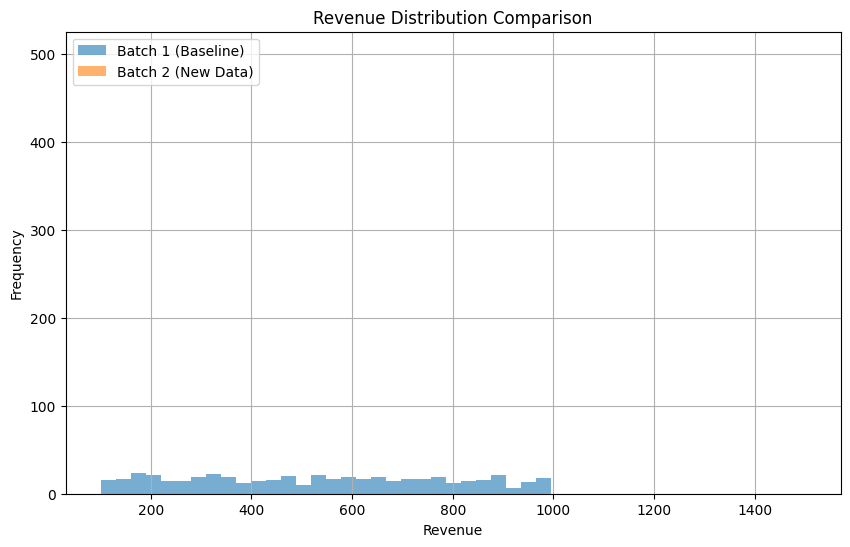

In [69]:
import matplotlib.pyplot as plt

df_batch1_pd = pd.read_csv('sales_data_batch1.csv')
df_batch2_pd = pd.read_csv('sales_data_batch2.csv')

plt.figure(figsize=(10,6))
plt.hist(df_batch1_pd['revenue'], bins=30, alpha=0.6, label='Batch 1 (Baseline)')
plt.hist(df_batch2_pd['revenue'], bins=30, alpha=0.6, label='Batch 2 (New Data)')
plt.title('Revenue Distribution Comparison')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

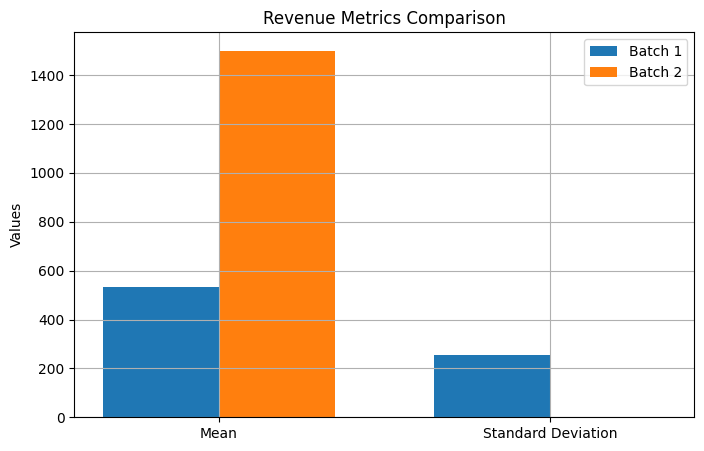

In [70]:
# Prepare data for plotting
metrics = ['Mean', 'Standard Deviation']
batch1_values = [stats_batch1['revenue']['mean'], stats_batch1['revenue']['stddev']]
batch2_values = [stats_batch2['revenue']['mean'], stats_batch2['revenue']['stddev']]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, batch1_values, width, label='Batch 1')
rects2 = ax.bar(x + width/2, batch2_values, width, label='Batch 2')

# Labels
ax.set_ylabel('Values')
ax.set_title('Revenue Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.grid(True)
plt.show()

In [71]:
schema_drift_df = pd.read_csv('reports/schema_drift_report.csv')
value_drift_df = pd.read_csv('reports/value_drift_report.csv')
null_value_df = pd.read_csv('reports/null_value_report.csv')

master_report_content = []

# Schema Drift
master_report_content.append("=== SCHEMA DRIFT REPORT ===\n")
if not schema_drift_df.empty:
    for idx, row in schema_drift_df.iterrows():
        master_report_content.append(f"- [{row['Drift_Type']}] Column: {row['Column']} | Details: {row['Details']}")
else:
    master_report_content.append("No schema drift detected.\n")

# Value Drift
master_report_content.append("\n\n=== VALUE DRIFT REPORT ===\n")
for idx, row in value_drift_df.iterrows():
    batch1_mean = row['Batch1_Mean']
    batch2_mean = row['Batch2_Mean']
    batch1_std = row['Batch1_StdDev']
    batch2_std = row['Batch2_StdDev']
    
    master_report_content.append(
        f"- Column: {row['Column']} | Mean (Batch1): {batch1_mean:.2f} → Mean (Batch2): {batch2_mean:.2f} | "
        f"StdDev (Batch1): {batch1_std:.2f} → StdDev (Batch2): {batch2_std:.2f}"
    )

# Null Value Drift
master_report_content.append("\n\n=== NULL VALUE REPORT ===\n")
for idx, row in null_value_df.iterrows():
    master_report_content.append(f"- Column: {row['Column']} | Null Percentage: {row['Null_Percentage']:.2f}%")

with open('reports/master_drift_report.txt', 'w', encoding='utf-8') as f:
    for line in master_report_content:
        f.write(line + "\n")

print("Master Drift Report saved to 'reports/master_drift_report.txt'")

Master Drift Report saved to 'reports/master_drift_report.txt'
